In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List, Union, Optional
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import stats

In [2]:
class OptimaOutput:
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None):

        self.job_name = str(job_name)
        if optima_path == None:
            self.optima_path = Path("/home/nvme/Opt/outputs")
        self.job_folder = self.optima_path / job_name
        file_path = self.job_folder / "mechanismInfo.txt"
        try:
            with open(file_path, "r") as f:
                self.mech_info = f.read()
        except Exception as e:
            raise e

In [3]:
class OptimaMechtest(OptimaOutput):
    def __init__(self, job_name: Union[str, Path],
                 optima_path: Optional[Union[str, Path]] = None,
                 errf_type: Union[str, List[str]] = "default"):
        super().__init__(job_name, optima_path)

        self._errf_files = {
           "default": "errfValues",
           "data_series": "errfValues_by_data_series", 
           "points": "errfValues_by_points",
           "species": "errfValues_by_species"
            }
        
        if (self.job_folder / "debug").exists():
            self.all_data = {}
            for csv_data in (self.job_folder / "debug").glob("*.csv"):
                try:
                    self.all_data[csv_data.stem] = pd.read_csv(csv_data)
                except Exception as e:
                    print(e)

        if (self.job_folder / "mechTestResults_BCRN6.csv").exists():
            all_sheets_dP = pd.read_csv(self.job_folder / "mechTestResults_BCRN6.csv",  # dP as in the info in dataPoints
                                        header=None,
                                        delimiter=';',
                                        index_col=False,
                                        names=['xml', 'time_point', 'species', 'dP_val', 'sim_val'])
            self.get_the34(all_sheets_dP=all_sheets_dP)

        try:
            if isinstance(errf_type, str):
                file_name = self._errf_files.get(errf_type, "errfValues")
                self.errfValues = pd.read_csv(
                    self.job_folder / file_name,
                    header = 9,
                    delim_whitespace = True
                )
            else:
                self.errfValues = {}
                for e_type in errf_type:
                    file_name = self._errf_files.get(errf_type, "errfValues")
                    self.errfValues[e_type] = pd.read_csv(
                        self.job_folder / file_name,
                        header = 9,
                        delim_whitespace = True
                    )
                
            if (self.job_folder / "sigmas").is_file():
                self.sigmas = pd.read_csv(
                    self.job_folder / "sigmas",
                    skiprows = [0,2],
                    delim_whitespace = True
                )
        except Exception as e:
            raise e
        
    def get_the34(self, all_sheets_dP):
        self.xml_dP: dict[str: pd.DataFrame] = {}
        time_point = 0
        species = 'ilyen_species_tuti_nem_lesz'
        for idx, row in all_sheets_dP.iterrows():
            xml_name = row.xml
            sim_val = row.sim_val

            if row.species == species:
                time_point = time_point + 1
            else:
                species = row.species
                time_point = 1
            
            if xml_name not in self.xml_dP.keys():
                self.xml_dP[xml_name] = pd.DataFrame()  # Initialize inner dict
            self.xml_dP[xml_name].loc[time_point, species] = sim_val
            

In [150]:
class OptimaSensitivity(OptimaOutput):
    def __init__(self, job_name: Union[str, Path], optima_path: Optional[Union[str, Path]] = None):
        super().__init__(job_name, optima_path)
        try:
            self.reactionList = pd.read_csv(self.job_folder / "reactionList.txt",
                                            delim_whitespace = True
                                            )
            self.sensitivityResults = pd.read_csv(self.job_folder / "sensitivityResults",
                                                  header = 6,
                                                  delim_whitespace = True
                                            )
        except Exception as e:
            raise e
    def _calc_overal_impact(self, sigma, data_m):
        I = sigma * np.sqrt(1/(N_cond*N_tim)*s**2)
        return I
    def calc_normalised_sensitivity(self):
        return

In [155]:
mech = OptimaMechtest("20250123_BCRN_cor.opp")

stac_eq_df = pd.concat({k: v.iloc[-1] for k, v in mech.all_data.items()}, axis=1)
followed34 = pd.concat({k: v.iloc[-1] for k, v in xml_dP.items()}, axis=1)
df_basal = stac_eq_df.iloc[3:-1].T * 10e9
df_followed34 = followed34.T * 10e9             # igy nM-ben vannak
print(f"dimenziok: (xml_szam, species_szam)\nall:{df_basal.shape}\nfollowed:{df_followed34.shape}")

dimenziok: (xml_szam, species_szam)
all:(20, 83)
followed:(20, 34)


In [164]:
basal_cov = df_basal.cov()
followed34_cov = df_followed34.cov()
basal_corr = df_basal.corr()
followed34_corr = df_followed34.corr()
print(followed34_corr)

                 AC      AKTA      AMPK  ATG5  ATG5T      BCL2  BCL2_BAX  \
AC         1.00e+00  2.11e-01 -4.14e-02  0.13  -0.16 -8.38e-03  5.40e-02   
AKTA       2.11e-01  1.00e+00 -1.10e-01  0.20  -0.27  2.30e-01  2.24e-01   
AMPK      -4.14e-02 -1.10e-01  1.00e+00  0.18   0.32 -9.00e-02  2.96e-01   
ATG5       1.26e-01  2.00e-01  1.78e-01  1.00  -0.07  2.88e-01  2.88e-02   
ATG5T     -1.62e-01 -2.72e-01  3.25e-01 -0.07   1.00 -6.53e-01  1.21e-01   
BCL2      -8.38e-03  2.30e-01 -9.00e-02  0.29  -0.65  1.00e+00  1.67e-01   
BCL2_BAX   5.40e-02  2.24e-01  2.96e-01  0.03   0.12  1.67e-01  1.00e+00   
BCL2_PUMA -2.22e-01 -1.46e-01 -1.05e-01  0.06  -0.22  4.79e-01 -2.26e-02   
BEC1      -2.21e-01 -7.76e-02  9.68e-02  0.02   0.19 -4.38e-01 -2.84e-01   
BAX        3.03e-01  4.41e-01 -1.14e-01 -0.42   0.05 -4.36e-01 -1.62e-01   
BID        1.26e-02 -2.38e-01  1.81e-01 -0.07  -0.09  1.25e-01 -2.91e-01   
CA2ER      6.15e-01  2.06e-01 -3.05e-01  0.09  -0.07 -7.54e-02  2.52e-03   
CA2IC     -3

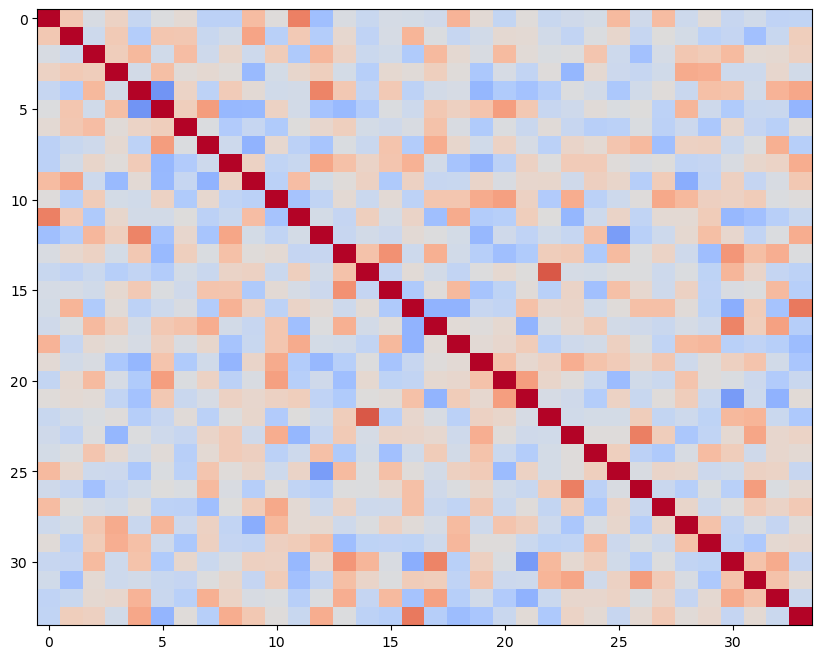

In [165]:
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 2)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(basal_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.savefig('test_all')
im = ax.imshow(followed34_corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.savefig('test_followed34')


In [ ]:
mech.job_folder


In [ ]:
#mvd = stats.multivariate_normal(mean=basal_mean, cov=basal_cov)
basal_mean = df_basal.mean()
basal_std = df_basal.std()
eigenvals = np.linalg.eigvals(basal_cov)
eigs = np.linalg.eig(basal_cov)

#np.random.multivariate_normal(basal_mean, basal_cov, tol=1, size=(100))

mv_normal = stats.multivariate_normal(mean=basal_mean, cov=basal_cov, allow_singular=True)
mv_normal

arr1 = np.nan_to_num(basal_corr, nan=0.0)
eigenvalues, eigenvectors = np.linalg.eigh(arr1)
# Sort eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
names = basal_corr.columns.to_numpy()[idx]

eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
print("Method 1 - PCA using numpy:")
print("Eigenvalues:", eigenvalues)
print("Explained variance ratio:", explained_variance_ratio)
print("\n")

Method 1 - PCA using numpy:
Eigenvalues: [ 1.17947635e+01  1.01282057e+01  7.90020332e+00  6.88884780e+00
  5.83840090e+00  5.15092186e+00  4.74499328e+00  4.35103071e+00
  3.69163253e+00  3.18434091e+00  2.92957768e+00  2.47189678e+00
  2.04317127e+00  1.68978611e+00  1.41777891e+00  1.33971937e+00
  9.06109879e-01  8.57985827e-01  6.70633531e-01  1.26855913e-07
  5.02674650e-08  4.97566171e-14  6.45852888e-15  1.56061507e-15
  1.20700299e-15  1.13090176e-15  1.02354081e-15  8.78676598e-16
  7.59588276e-16  7.25317396e-16  6.33700769e-16  6.08258777e-16
  5.30989646e-16  5.30959790e-16  4.95373463e-16  4.10584949e-16
  4.07013140e-16  3.22013136e-16  2.73453880e-16  2.73190280e-16
  2.12440496e-16  2.11767605e-16  2.09631501e-16  1.60317443e-16
  1.38283669e-16  1.08336517e-16  1.98775949e-17  5.78603559e-32
  5.78943168e-33 -2.23501607e-33 -9.93709789e-33 -4.60850698e-32
 -1.26225785e-17 -2.25123630e-17 -2.94184556e-17 -9.27800451e-17
 -1.40651447e-16 -1.62027193e-16 -1.87233280e-16 

In [7]:
vec = eigenvectors[:,1]
sorted_indices = np.argsort(np.abs(vec))[::-1]
sorted_vec = vec[sorted_indices]
for idx,x in enumerate(sorted_vec):
    if abs(x) > 0.1: 
        print(names[idx],":",x)

x_UVG : -0.2862512293379011
x_ULKA : -0.2719995992624176
x_ULK : -0.2719995819261349
x_TSCA : -0.2719921702497337
x_TSC : 0.21436403364623216
x_TG_SERCA : 0.19397437143140844
x_TG : -0.19235501214065684
x_TBID : -0.17340339368024948
x_SERCAA : -0.16853096298831152
x_SERCA : 0.15976529628789968
x_RHEBA : 0.15955155349357444
x_RHEB : 0.15943776221601053
x_REF : -0.15550876163606717
x_RAP : -0.15008578568700895
x_PUMA : 0.14912739648255235
x_PROCASP : -0.14880987058509507
x_PREAUT : -0.1488097023924942
x_PLCEA : -0.14834472153884662
x_PLCE : 0.1426346665535872
x_PKC_CA2IC : 0.13926026957018312
x_PKC : 0.13552226158921604
x_PKAA : 0.13265230066383898
x_PKA : 0.12717491800991532
x_PIP2 : -0.12403194619666369
x_PI3KA : -0.12218497557506147
x_PI3K : 0.1205899901105935
x_PHAG : 0.1183032026410962
x_P53A_BCL2 : 0.116835183989363
x_P53A : 0.10779391679694682
